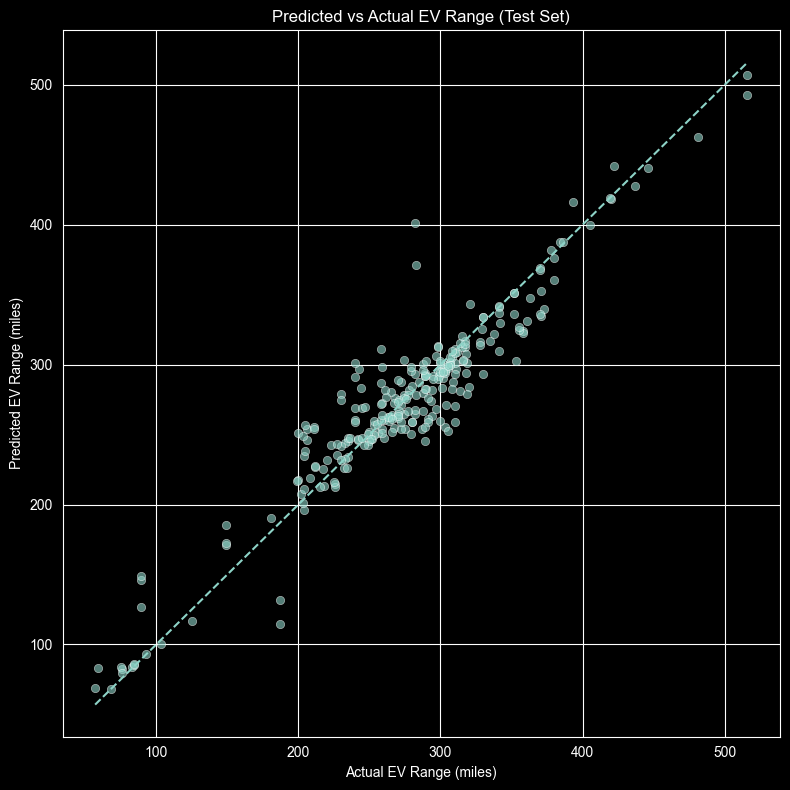

In [76]:
# ============================================================
# Visualization 1: Predicted vs Actual EV Range (Test Set)
# Purpose:
# - Check overall model fit
# - Identify bias, spread, and outliers
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Load artifacts produced by 02_model_training.ipynb (test-set predictions + summaries)
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path("..")  # notebooks/ -> project root
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

FIGURES_DIR = PROJECT_ROOT / "figures"
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PRED_PATH = DATA_PROCESSED / "pred_df_test.csv"
BRAND_YEAR_PATH = DATA_PROCESSED / "brand_year_error_summary.csv"
MODEL_SUMMARY_PATH = DATA_PROCESSED / "model_error_summary.csv"

# Read prediction dataframe (required for all plots below)
pred_df = pd.read_csv(PRED_PATH)
pred_df.head()

# Optional: load summaries if/when you need them later in this notebook
brand_year_summary = pd.read_csv(BRAND_YEAR_PATH) if BRAND_YEAR_PATH.exists() else None
model_error_summary = pd.read_csv(MODEL_SUMMARY_PATH) if MODEL_SUMMARY_PATH.exists() else None

pred_df.head()

# Scatter plot
plt.figure(figsize=(8, 8))
sns.scatterplot(
    x=pred_df["y_true"],
    y=pred_df["y_pred"],
    alpha=0.6
)

# Identity line (perfect predictions)
min_val = min(pred_df["y_true"].min(), pred_df["y_pred"].min())
max_val = max(pred_df["y_true"].max(), pred_df["y_pred"].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

plt.xlabel("Actual EV Range (miles)")
plt.ylabel("Predicted EV Range (miles)")
plt.title("Predicted vs Actual EV Range (Test Set)")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "predicted_vs_actual.png", dpi=300)
plt.show()

In [77]:
# Save figure (keeps project modular + reproducible)
out_path = FIGURES_DIR / "pred_vs_actual_test.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
print("Saved:", out_path.resolve())

Saved: /Users/saam/PycharmProjects/ev-range-prediction/figures/pred_vs_actual_test.png


<Figure size 640x480 with 0 Axes>

In [78]:
# Load artifacts produced by 02_model_training.ipynb
import pandas as pd
from pathlib import Path

# Paths (notebooks/ -> project root)
PROJECT_ROOT = Path("..")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
FIGURES_DIR = PROJECT_ROOT / "figures"

# Create folders if missing (safe)
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Artifact paths
PRED_PATH = DATA_PROCESSED / "pred_df_test.csv"
BRAND_YEAR_PATH = DATA_PROCESSED / "brand_year_error_summary.csv"
MODEL_SUMMARY_PATH = DATA_PROCESSED / "model_error_summary.csv"

# Load
pred_df = pd.read_csv(PRED_PATH)
brand_year_error_summary = pd.read_csv(BRAND_YEAR_PATH)
model_error_summary = pd.read_csv(MODEL_SUMMARY_PATH)

print("Loaded:", PRED_PATH.name, BRAND_YEAR_PATH.name, MODEL_SUMMARY_PATH.name)
print("pred_df shape:", pred_df.shape)
pred_df.head()

Loaded: pred_df_test.csv brand_year_error_summary.csv model_error_summary.csv
pred_df shape: (262, 6)


,make,model,year,y_true,y_pred,abs_error
0,GMC,Hummer EV Pickup 2M20,2024,311,297.143333,13.856667
1,Vinfast,VF 8 Plus,2025,235,245.623333,10.623333
2,Rivian,R1T Performance Dual Large (22in),2024,341,341.333333,0.333333
3,Toyota,bZ4X,2024,252,246.756667,5.243333
4,Rivian,R1S Quad Large (20in),2024,289,291.833333,2.833333


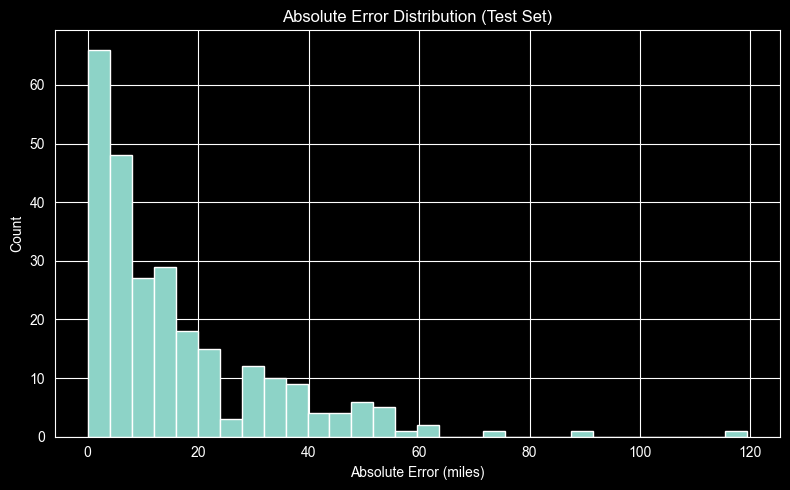

Saved: /Users/saam/PycharmProjects/ev-range-prediction/figures/abs_error_distribution.png


In [79]:
# Absolute error distribution (helps show tail risk)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(pred_df["abs_error"], bins=30)
plt.title("Absolute Error Distribution (Test Set)")
plt.xlabel("Absolute Error (miles)")
plt.ylabel("Count")
plt.tight_layout()

out_path = FIGURES_DIR / "abs_error_distribution.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close()

print("Saved:", out_path.resolve())

In [80]:
# Mean absolute error by brand (test set only)
brand_error = (
    pred_df
    .groupby("make", as_index=False)
    .agg(
        mean_abs_error=("abs_error", "mean"),
        vehicle_count=("abs_error", "size")
    )
    .sort_values("mean_abs_error", ascending=False)
)

brand_error.head(10)

,make,mean_abs_error,vehicle_count
2,BYD,63.825000,2
11,Honda,51.750000,3
5,Chevrolet,32.019259,9
18,MINI,31.033333,1
12,Hyundai,28.849091,11
8,Ford,27.294583,8
15,Kia,25.889394,11
21,Mitsubishi,24.376667,1
30,Vinfast,21.940000,2
32,Volvo,21.324286,7


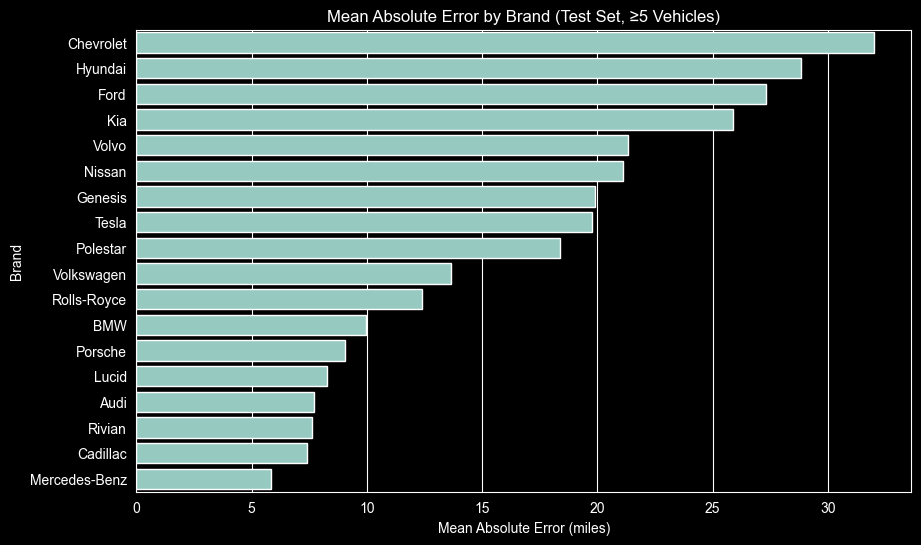

Saved: /Users/saam/PycharmProjects/ev-range-prediction/figures/mae_by_brand.png


In [81]:
# --------------------------------------------
# Mean Absolute Error by Brand
# (filter to brands with >= 5 test vehicles)
# --------------------------------------------

# Start from the test-set predictions table (this MUST have `make` and `abs_error`)
# If you loaded from CSV, make sure pred_df exists and includes `make` + `abs_error`.

# 1) Build a clean brand-level summary directly from pred_df (most reliable)
brand_summary = (
    pred_df
    .groupby("make", as_index=False)
    .agg(
        mean_abs_error=("abs_error", "mean"),
        vehicle_count=("abs_error", "size")
    )
)

# 2) Filter to brands with enough support
brand_summary_filtered = (
    brand_summary[brand_summary["vehicle_count"] >= 5]
    .sort_values("mean_abs_error", ascending=False)
)

# 3) Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=brand_summary_filtered,
    x="mean_abs_error",
    y="make"
)

plt.title("Mean Absolute Error by Brand (Test Set, ≥5 Vehicles)")
plt.xlabel("Mean Absolute Error (miles)")
plt.ylabel("Brand")

out_path = FIGURES_DIR / "mae_by_brand.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", out_path.resolve())

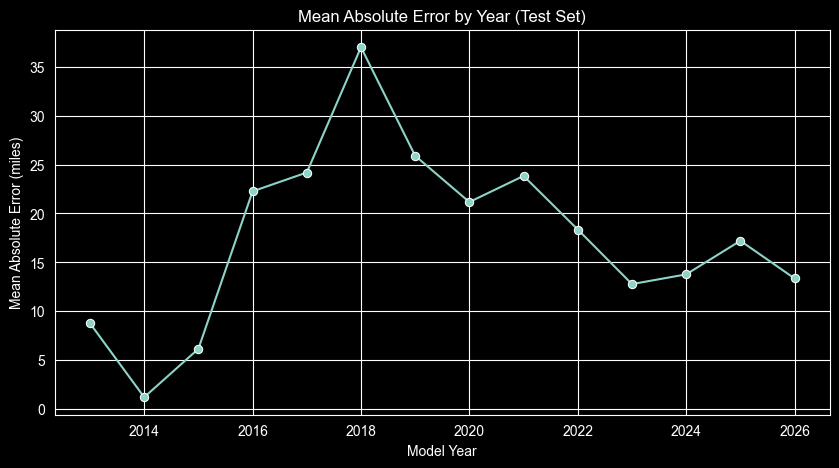

Saved: /Users/saam/PycharmProjects/ev-range-prediction/figures/mae_by_year.png


In [82]:
# --------------------------------------------
# Mean Absolute Error by Year (Test Set)
# --------------------------------------------

year_summary = (
    pred_df
    .groupby("year", as_index=False)
    .agg(
        mean_abs_error=("abs_error", "mean"),
        vehicle_count=("abs_error", "size")
    )
    .sort_values("year")
)

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=year_summary,
    x="year",
    y="mean_abs_error",
    marker="o"
)

plt.title("Mean Absolute Error by Year (Test Set)")
plt.xlabel("Model Year")
plt.ylabel("Mean Absolute Error (miles)")

out_path = FIGURES_DIR / "mae_by_year.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", out_path.resolve())

In [83]:
# --------------------------------------------
# Mean Absolute Error by Support Level
# (reliable vs low_support)
# --------------------------------------------

# 1) Compute support per (make, model) directly from pred_df
support_lookup = (
    pred_df
    .groupby(["make", "model"], as_index=False)
    .agg(vehicle_count=("abs_error", "size"))
)

# 2) Apply support labeling rule (same rule as Day 6)
support_lookup["support_level"] = support_lookup["vehicle_count"].apply(
    lambda n: "reliable" if n >= 2 else "low_support"
)

# 3) Merge support_level onto each test prediction row
pred_with_support = pred_df.merge(
    support_lookup[["make", "model", "support_level"]],
    on=["make", "model"],
    how="left"
)

# 4) Summarize MAE by support level
support_summary = (
    pred_with_support
    .groupby("support_level", as_index=False)
    .agg(
        mean_abs_error=("abs_error", "mean"),
        median_abs_error=("abs_error", "median"),
        vehicle_count=("abs_error", "size")
    )
    .sort_values("mean_abs_error", ascending=False)
)

display(support_summary)

,support_level,mean_abs_error,median_abs_error,vehicle_count
1,reliable,19.630164,13.156667,61
0,low_support,14.988905,8.966667,201


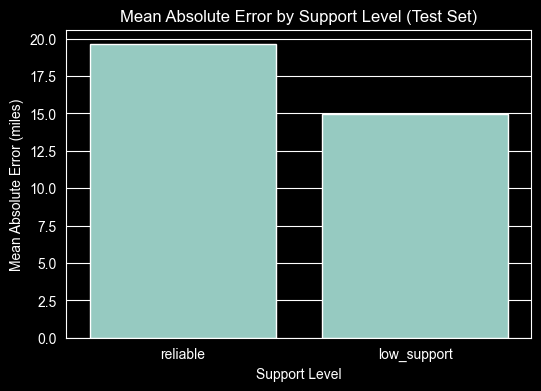

Saved: /Users/saam/PycharmProjects/ev-range-prediction/figures/mae_by_support_level.png


In [84]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=support_summary,
    x="support_level",
    y="mean_abs_error"
)

plt.title("Mean Absolute Error by Support Level (Test Set)")
plt.xlabel("Support Level")
plt.ylabel("Mean Absolute Error (miles)")

out_path = FIGURES_DIR / "mae_by_support_level.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", out_path.resolve())

In [85]:
# --------------------------------------------
# Worst Prediction Errors (Test Set)
# --------------------------------------------

worst_errors = (
    pred_df
    .sort_values("abs_error", ascending=False)
    .head(10)
)

display(worst_errors)

# Save worst errors table for reference / README
out_path = DATA_PROCESSED / "worst_errors.csv"
worst_errors.to_csv(out_path, index=False)
print("Saved:", out_path.resolve())

Saved: /Users/saam/PycharmProjects/ev-range-prediction/data/processed/worst_errors.csv


## Key Error Analysis Takeaways

- Overall model predictions closely follow the ideal y = x line, indicating strong calibration across most EV ranges.
- Absolute errors are right-skewed: most predictions fall within ~0–20 miles, with a small number of high-error outliers.
- Brand-level performance varies:
  - Some manufacturers (e.g., Chevrolet, Hyundai, Ford) show higher average errors, likely due to broader model variance.
  - Luxury and performance-focused brands (e.g., Mercedes-Benz, BMW, Porsche, Rivian) exhibit lower average errors.
- Error by model year suggests:
  - Older EVs show higher uncertainty, likely due to limited data and early-generation battery tech.
  - Recent model years benefit from more consistent range characteristics.
- Support-level analysis confirms:
  - Models with limited representation ("low_support") appear artificially accurate.
  - Reliable conclusions should prioritize models with sufficient sample size.
- The largest prediction errors highlight edge cases where the model struggles, guiding future feature improvements.